# <i class="fa-solid fa-tree"></i> Decision Trees

Decision Trees are powerful and intuitive models used for both classification and regression problems. They work by recursively partitioning the feature space into smaller regions and assigning a prediction to each one. The tree structure is easy to interpret and visualise, making it a popular choice for understanding the relationship between inputs and outputs.

At their core, decision trees split the dataset into subsets based on feature values. Each split is chosen to maximise some purity measure, aiming to make the resulting subsets as homogeneous as possible.

- **Nodes**: Points where decisions are made (internal nodes) or outcomes are assigned (leaf nodes).
- **Leaves (terminal nodes)**: Regions of the feature space with a predicted outcome.
- **Splits**: Binary decisions on feature values, e.g., “is BMI ≤ 25?”.

The process is greedy and top-down, called **recursive binary splitting**.

---

## Regression Trees

The general usage of regression trees is identical to previous regression models:

```{code-block} python
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit()
```

As you learned in the lecture, there are a few additional parameters which we can choose, such as *splitting criteria* (where to split) or *stopping criteria* (when to stop splitting). You can look these up in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). To see how these models perform, we can simply plot the predictions for two different models on synthetic data.

1. Generate data:

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(100, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(20))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

2. Fit two decision tree regressors to the data

In [2]:
from sklearn.tree import DecisionTreeRegressor

model1 = DecisionTreeRegressor(max_depth=2)
model2 = DecisionTreeRegressor(max_depth=6)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train);

3. Plot the predictions to see how different models behave:

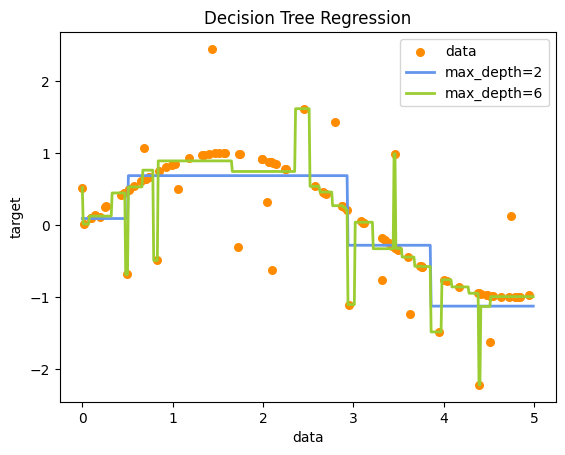

In [3]:
import matplotlib.pyplot as plt

X_range = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
pred1 = model1.predict(X_range)
pred2 = model2.predict(X_range);

plt.figure()
plt.scatter(X, y, s=30, c="darkorange", label="data")
plt.plot(X_range, pred1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_range, pred2, color="yellowgreen", label="max_depth=6", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend();

You can see that the `max_depth=2` model is underfitting, while the `max_depth=6` is overfitting. We can also can evaluate the models with usual performance metrics such as $R^2$:

In [4]:
from sklearn.metrics import r2_score

r2_1 = r2_score(y_test, model1.predict(X_test))
r2_2 = r2_score(y_test, model2.predict(X_test))

print(f"R² (max_depth=2): {r2_1:.3f}")
print(f"R² (max_depth=6): {r2_2:.3f}")

R² (max_depth=2): 0.571
R² (max_depth=6): 0.472


---

## Classification Trees

The general usage of classification trees is identical to previous classification models:

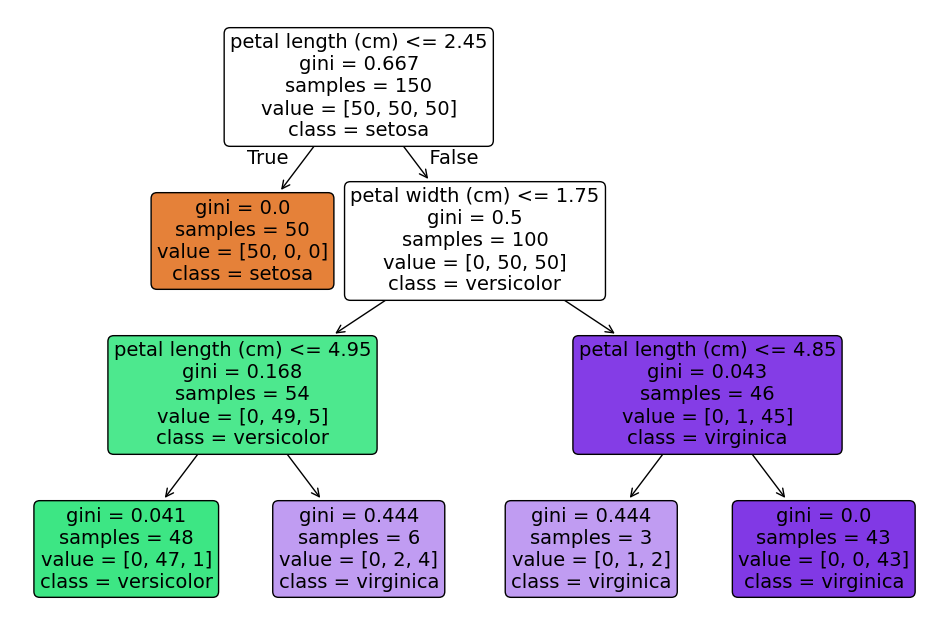

In [5]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_iris

# Load data
iris = load_iris()
X, y = iris.data, iris.target

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, fontsize=14);

The tree plot of the fitted model contains the following information:

- **Decision nodes**  
  - These are the rectangles with a splitting criterion (e.g. `feature ≤ threshold`)  
  - They represent the points where the model splits the data and asks “which branch next?”  

- **Edges**  
  - The lines connecting nodes  
  - Left edge follows the `true` branch (node condition met), right edge the `false` branch

- **Leaf nodes**  
  - The terminal rectangles without further splits  
  - The leaf nodes mark the final predicted class (`class`)

- **Color fill**  
  - The shade corresponds to the majority class at that node  
  - The epth of color indicates purity (dark = almost all one class; light = mixture)  

- **Gini or entropy (implicitly encoded as the color fill)**  
  - Determines how “mixed” a node is when choosing splits  
  - Pure nodes (all same class) are darkest with the color of the feature, impure nodes are white

- **Tree depth**  
  - The number of levels indicate how many successive decisions are made  
  - Capped by the `max_depth` parameter to control complexity

Another nice illustration is plotting the decision boundaries. As this works mostly with 2 features, we plot pairwise feature combinations:

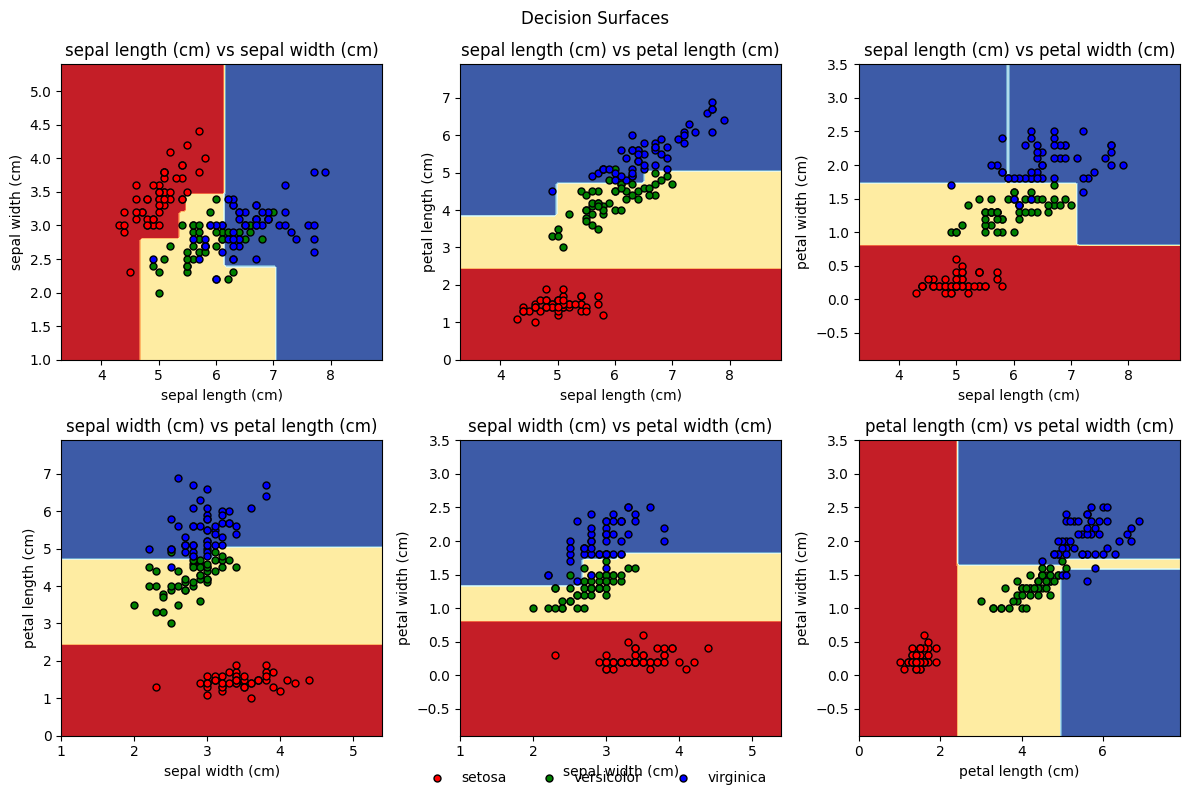

In [6]:
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

# Plot settings
pairs      = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
n_classes  = len(iris.target_names)
colors     = ["r", "g", "b"]
fig, axes  = plt.subplots(2, 3, figsize=(12, 8))
axes       = axes.ravel()

for ax, (i, j) in zip(axes, pairs):
    X_sub = X[:, [i, j]]
    clf = DecisionTreeClassifier(max_depth=4)
    clf.fit(X_sub, y)

    # Plot decision surface
    disp = DecisionBoundaryDisplay.from_estimator(
              clf, X_sub, cmap=plt.cm.RdYlBu, response_method="predict", 
              ax=ax, xlabel=iris.feature_names[i], ylabel=iris.feature_names[j])

    # Overlay training points
    for class_idx, color in zip(range(n_classes), colors):
        mask = (y == class_idx)
        ax.scatter(X_sub[mask, 0], X_sub[mask, 1], c=color, label=iris.target_names[class_idx], edgecolor="k", s=25)

    ax.set_title(f"{iris.feature_names[i]} vs {iris.feature_names[j]}")

# Legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=n_classes, frameon=False)
fig.suptitle("Decision Surfaces")
plt.tight_layout();

---

## Overfitting

Large trees tend to overfit. To counter this we can do multiple things:

- **Prune the full-grown tree**, also called bottom-up pruning or cost-complexity pruning (we saw this in the lecture)
- **Tune the hyperparameters** that control the tree-growing behavior, also called top-down pruning.
- **Ensemble methods**: bagging, random forests and boosting (will be introduced later)

### Cost Complexity Pruning & Hyperparameter Tuning

Cost complexity pruning means we add a penalty for tree size:

$\text{Total Cost} = \text{RSS or Classification Error} + \alpha \cdot \text{Tree Size}$

In scikit-learn this is controlled by `ccp_alpha`  
  - `ccp_alpha = 0` -> no pruning -> full-grown tree  
  - `ccp_alpha > 0` -> pruning -> smaller tree  

We can further control the tree growing behaviour with hyperparameters such as

- `max_depth`
- `min_samples_split`
- `min_samples_leaf`

We can use a grid search to find the best combination for some of these hyperparameters:

In [7]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

param_grid = {
    'ccp_alpha':         np.linspace(0.0, 0.2, 10),
    'max_depth':         [2, 4, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf':  [1, 2, 4, 8],
}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Test set accuracy:", grid.score(X_test, y_test))

Best params: {'ccp_alpha': np.float64(0.0), 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5}
Test set accuracy: 0.9777777777777777


---

## Ensemble Methods

Single trees have high variance. They are prone to overfitting and generally are not competetive when compared to more sophisticated models such als support vector machines. Ensemble methods try to solve these issues by combining many trees to reduce variance (bagging, random forest) or bias (boosting).

### Bagging (Bootstrap Aggregation)

Bagging involves the following steps:

1. Create multiple bootstrapped samples of the training set
2. Train a tree on each
3. Aggregate predictions
   - Classification: majority vote
   - Regression: average prediction

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

bag = BaggingClassifier(n_estimators=100, random_state=0)
bag.fit(X_train, y_train)

accuracy_score(y_test, bag.predict(X_test))

0.9777777777777777

### Random Forest

Random Forest injects additional randomness by sub-sampling features at each split, further de-correlating the trees and improving variance reduction.

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

accuracy_score(y_test, rf.predict(X_test))

0.9777777777777777

Feature importance can be visualised as:

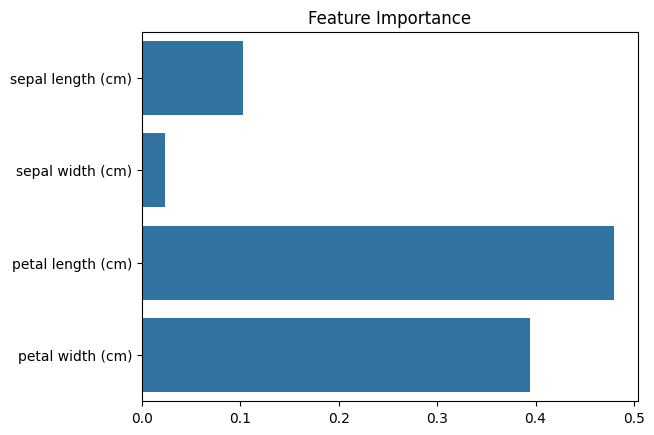

In [10]:
import seaborn as sns

sns.barplot(x=rf.feature_importances_, y=iris.feature_names)
plt.title("Feature Importance");

---

### Boosting

Boosting builds trees sequentially. Each tree focuses on the residual errors of the previous one. Important parameters are:

- `n_estimators`: number of trees
- `learning_rate`: shrinkag
- `max_depth`: tree depth

In [11]:
from xgboost import XGBClassifier

boost = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
boost.fit(X_train, y_train)
accuracy_score(y_test, boost.predict(X_test))

0.9777777777777777

---

## Summary

```{admonition} Summary
:class: note 

| Method            | Description                                      | Pros                                | Cons                                                  |
|-------------------|--------------------------------------------------|-------------------------------------|-------------------------------------------------------|
| **Decision Trees**| Split data via feature thresholds                | Highly interpretable, fast to train | High variance → prone to overfitting                  |
| **Bagging**       | Average many bootstrapped trees                  | Reduces variance / overfitting      | Less interpretable; larger memory footprint           |
| **Random Forest** | Bagging + random feature subsets at each split   | Further reduces variance; robust    | Slower to train and predict                           |
| **Boosting**      | Sequentially fit to previous residuals / errors  | Low bias → often very accurate      | Can overfit noisy data; sensitive to hyperparameters  |
```